In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

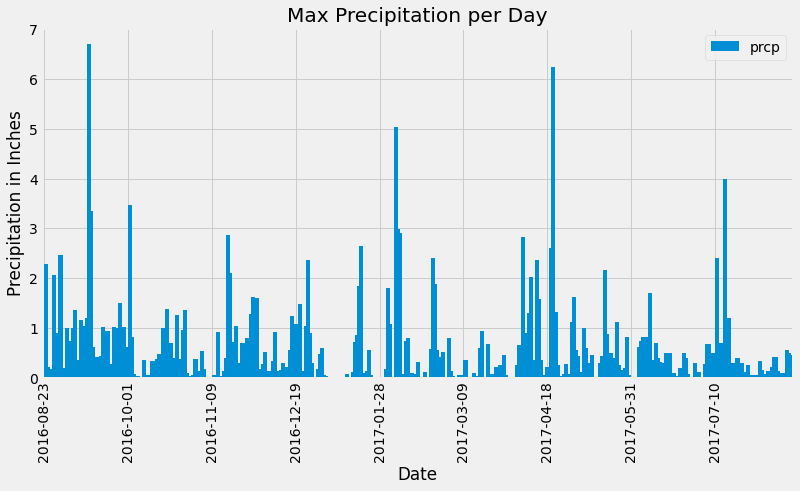

In [12]:
## Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the last data point in the database
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Calculate the date one year from the last data point in the database (2017-08-23)
year_from_latest_date = dt.date(2017, 8, 23) - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
prcp_in_timeframe = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= '2016-08-23')

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_in_timeframe, columns=['date', 'prcp'])

# Sort the dataframe by date
prcp_df = prcp_df.groupby('date')['prcp'].max().reset_index().set_index('date')
prcp_df = prcp_df.sort_values(by=['date'])
prcp_df

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(kind='bar', figsize=(12,6), width=2)
plt.title('Max Precipitation per Day')
plt.xlabel('Date')
plt.ylabel('Precipitation in Inches')
x_axis = np.arange(0, len(prcp_df), 41)
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, ['2016-08-23', '2016-10-01', '2016-11-09', '2016-12-19',\
                           '2017-01-28', '2017-03-09', '2017-04-18', '2017-05-31', '2017-07-10'])
plt.grid(True)
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
print(f"The mean precipitation in inches over the year is: {round(prcp_df['prcp'].mean(),2)}")
print(f"The standard deviation of precipitation in inches is: {round(prcp_df['prcp'].std(),2)}")

The mean precipitation in inches over the year is: 0.52
The standard deviation of precipitation in inches is: 0.83


In [14]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(Measurement).group_by(Measurement.station).count()
print(f"There are {stations_count} stations in this dataset.")

There are 9 stations in this dataset.


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()[0]

lowest_temp = session.query(Measurement.station, func.min(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
highest_temp = session.query(Measurement.station, func.max(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
average_temp = session.query(Measurement.station, func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

print(f"The most active station and its lowest temperature are: {lowest_temp}")
print(f"The most active station and its highest temperature are: {highest_temp}")
print(f"The most active station and its average temperature are: {average_temp}")

The most active station and its lowest temperature are: [('USC00519281', 54.0)]
The most active station and its highest temperature are: [('USC00519281', 85.0)]
The most active station and its average temperature are: [('USC00519281', 71.66378066378067)]


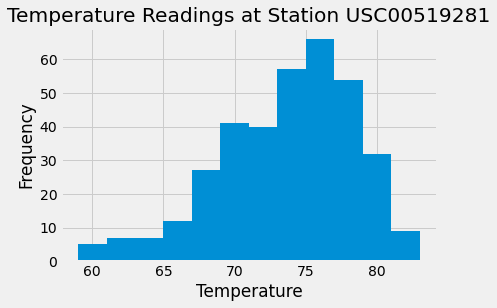

In [39]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Calculate the last data point in this station
session.query(Measurement.date).\
    order_by(Measurement.date.desc()).\
    filter(Measurement.station == most_active_station).first()

# Calculate the date one year from the last data point in the database (2017-08-18)
year_from_latest_date = dt.date(2017, 8, 18) - dt.timedelta(days = 365)

# Save the query results as a Pandas DataFrame and set the index to the station column
tobs_in_timeframe = session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.date >= year_from_latest_date).\
    filter(Measurement.station == most_active_station)
tobs_df = pd.DataFrame(tobs_in_timeframe, columns=['station', 'tobs']).set_index('station')

# Plot the results as a histogram with 12 bins
plt.hist(tobs_df['tobs'], bins=12)
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.title(f'Temperature Readings at Station {most_active_station}')
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
